
# Sberbank: Final Project Naya Data Scientist training course
By: Ayelet Ben-Hur Pik

In [1]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor # import the random forest model
from sklearn import  preprocessing # used for label encoding and imputing NaNs
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing
from sklearn.tree import export_graphviz

import datetime as dt
from datetime import datetime

import six
import seaborn as sn
color = sn.color_palette()
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
pd.options.display.max_columns = 100

In [3]:
sberbank_train=pd.read_csv('input/train.csv', parse_dates=['timestamp'], index_col='id' )
#sberbank_train_raw=pd.read_csv('input1/train.csv', parse_dates=['timestamp'] , index_col='id')
sberbank_test=pd.read_csv('input/test.csv', parse_dates=['timestamp'], index_col='id' )
df_macro = pd.read_csv('input/macro.csv', parse_dates=['timestamp'])


In [4]:
# df_macro.T
# sberbank_train.tail()
# sberbank_test.head()
#pd.options.display.max_columns = 100

In [4]:
sberbank_train.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,...,leisure_count_2000,sport_count_2000,market_count_2000,green_part_3000,prom_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,9576,5001.0,5,10309,11065.0,5,0,240.0,1,0,7,3,no,0,16,1,no,no,no,no,no,no,no,no,86206,40477,45729,21154,11007,10147,98207,52277,45930,36211,...,0,10,1,11.98,13.55,12,251554,23,1419204,68,639.68,1079.37,859.52,5,21,22,16,3,1,0,2,4,0,0,21,1,13.09,13.31,29,807385,52,4036616,152,708.57,1185.71,947.14,12,39,48,40,9,4,0,13,22,1,0,52,4,5850000
2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,6880,3119.0,5,7759,6237.0,8,0,229.0,1,0,6,1,yes,1,3,0,no,no,no,no,no,no,no,no,76284,34200,42084,15727,7925,7802,70194,35622,34572,29431,...,4,11,0,18.07,27.32,12,821986,14,491565,30,631.03,1086.21,858.62,1,11,11,4,2,1,0,1,7,0,6,19,1,10.26,27.47,66,2690465,40,2034942,177,673.81,1148.81,911.31,9,49,65,36,15,3,0,15,29,1,10,66,14,6000000
3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,5879,1463.0,4,6207,5580.0,7,0,1183.0,1,0,5,1,no,0,0,1,no,no,no,yes,no,no,no,no,101982,46076,55906,13028,6835,6193,63388,31813,31575,25292,...,0,8,5,12.14,26.46,8,110856,7,52550,41,697.44,1192.31,944.87,2,9,17,9,3,1,0,0,11,0,0,20,6,13.69,21.58,43,1478160,35,1572990,122,702.68,1196.43,949.55,10,29,45,25,10,3,0,11,27,0,4,67,10,5700000
4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,13087,6839.0,9,13670,17063.0,10,0,NaN,1,0,17,6,no,0,11,4,no,no,no,no,no,no,no,no,21155,9828,11327,28563,14680,13883,120381,60040,60341,29529,...,0,13,2,20.79,3.57,4,167000,12,205756,32,718.75,1218.75,968.75,0,5,14,10,3,0,0,1,2,0,0,18,3,14.18,3.89,8,244166,22,942180,61,931.58,1552.63,1242.11,4,7,21,15,11,2,1,4,4,0,0,26,3,13100000
5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,5706,3240.0,7,6748,7770.0,9,0,562.0,4,2,25,2,no,0,10,93,no,no,no,yes,yes,no,no,no,28179,13522,14657,13368,7159,6209,68043,34236,33807,26760,...,17,21,3,5.06,8.62,305,3420907,60,

In [5]:
# removing extreme price per sqm
sberbank_train.loc[sberbank_train.full_sq == 0, 'full_sq'] = 50
sberbank_train = sberbank_train[sberbank_train.price_doc/sberbank_train.full_sq <= 600000]
sberbank_train = sberbank_train[sberbank_train.price_doc/sberbank_train.full_sq >= 10000]

In [6]:
# Create a vector containing the id's for our predictions
id_sberbank_test = sberbank_test.index

#Create a vector of the target variables in the training set
# Transform target variable so that loss function is correct (ie we use RMSE on transormed to get RMLSE)
# ylog1p_train will be log(1+y), as suggested by https://github.com/dmlc/xgboost/issues/446#issuecomment-135555130
#ylog1p_train = np.log1p(sberbank_train['price_doc'].values)

In [7]:
sberbank_test.shape

(7662, 290)

In [8]:
# Create joint train and test set to make data wrangling quicker and consistent on train and test
sberbank_train['source']='train'
sberbank_test['source']='test'

cols = list(sberbank_train.columns.values)

#sberbank_all=sberbank_train.append(sberbank_test)
# sberbank_all = sberbank_all.join(df_macro, on='timestamp', rsuffix='_macro')


In [9]:
sberbank_all = pd.concat([sberbank_train, sberbank_test])

sberbank_all=sberbank_all[cols] #reordering the columns


In [10]:
#sberbank_all.tail()
sberbank_all[sberbank_all['source']=='test'].head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,...,sport_count_2000,market_count_2000,green_part_3000,prom_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,source
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30474,2015-07-01,39.0,20.7,2.0,9.0,1.0,1998.0,1.0,8.9,3.0,Investment,Juzhnoe Butovo,2.615514e+07,178264,0.137846,0.041116,14080,11926.0,11,14892,24750.0,13,1,NaN,1,0,13,4,no,0,4,4,no,no,no,no,no,no,no,no,102618,47681,54937,30808,16251,14557,121369,59138,62231,26087,...,5,0,14.69,2.87,0,0,3,73000,12,781.82,1227.27,1004.55,1,2,2,7,0,0,0,1,3,1,0,7,0,21.58,4.69,1,37550,8,299166,19,676.47,1088.24,882.35,2,5,4,8,0,0,0,1,10,1,0,14,1,NaN,test
30475,2015-07-01,79.2,NaN,8.0,17.0,1.0,0.0,3.0,1.0,1.0,OwnerOccupier,Poselenie Vnukovskoe,2.553630e+07,4001,0.496315,0.007122,275,NaN,0,264,NaN,0,0,NaN,0,0,0,0,no,0,1,0,no,no,no,no,no,no,no,no,17790,8350,9443,574,297,277,2566,1356,1211,861,...,1,0,39.50,3.32,0,0,2,22000,10,680.00,1200.00,940.00,0,1,6,2,1,0,0,1,5,0,0,7,0,39.10,7.70,2,177300,6,231300,20,733.33,1250.00,991.67,2,4,8,4,1,1,0,2,11,0,1,12,1,NaN,test
30476,2015-07-01,40.5,25.1,3.0,5.0,2.0,1960.0,2.0,4.8,2.0,Investment,Perovo,9.946335e+06,139322,0.065409,0.225825,6400,2232.0,7,6558,7966.0,7,0,1548.0,3,0,13,0,no,0,2,7,yes,no,yes,yes,no,no,no,no,36154,16222,19932,13799,6937,6862,91795,44734,47061,33728,...,14,4,45.86,9.08,8,215237,6,39106,37,608.33,1069.44,838.89,1,8,19,7,2,0,0,2,3,0,5,22,4,25.62,13.59,27,427889,26,1024431,179,668.97,1132.18,900.57,5,53,64,42,11,4,0,10,21,0,10,71,11,NaN,test
30477,2015-07-01,62.8,36.0,17.0,17.0,1.0,2016.0,2.0,62.8,3.0,OwnerOccupier,Poselenie Voskresenskoe,2.149409e+07,7122,0.262459,0.017647,489,NaN,0,469,NaN,0,0,NaN,0,0,0,2,no,0,0,0,no,no,no,no,no,no,no,no,9553,4529,5024,1021,529,493,4568,2414,2155,1533,...,0,0,34.87,1.34,0,0,0,0,1,300.00,500.00,400.00,0,1,0,0,0,0,0,0,4,0,0,0,0,24.25,1.66,0,0,0,0,5,1560.00,2500.00,2030.00,0,1,0,1,1,2,0,0,10,0,0,2,0,NaN,test
30478,2015-07-01,40.0,40.0,17.0,17.0,1.0,0.0,1.0,1.0,1.0,OwnerOccupier,Poselenie Vnukovskoe,2.553630e+07,4001,0.496315,0.007122,275,NaN,0,264,NaN,0,0,NaN,0,0,0,0,no,0,1,0,no,no,no,no,no,no,no,no,17790,8350,9443,574,297,277,2566,1356,1211,861,...,3,0,41.64,2.11,0,0,2,22000,9,700.00,1222.22,961.11,0,1,5,2,1,0,0,1,4,0,0,6,0,35.62,6.96,1,117300,4,201300,20,747.37,1263.16,10

In [11]:
#sberbank_all['timestamp_new']=pd.to_datetime(sberbank_all['timestamp'])
sberbank_all['year']=sberbank_all['timestamp'].dt.year
sberbank_all['month']=sberbank_all['timestamp'].dt.month
sberbank_all['q']=sberbank_all['timestamp'].dt.quarter

sberbank_all['price_doc'].fillna(value=1,inplace=True)
# ylog1p_doc will be log(1+y), as suggested by https://github.com/dmlc/xgboost/issues/446#issuecomment-135555130
sberbank_all['ylog1p_doc'] = np.log1p(sberbank_all['price_doc'].values)

In [12]:
sberbank_all.tail()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,...,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,source,year,month,q,ylog1p_doc
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
38131,2016-05-26,52.20,31.8,10.0,12.0,5.0,1973.0,2.0,9.1,2.0,Investment,Kon'kovo,7.811375e+06,153248,0.127002,0.135650,7517,2627.0,5,7960,9650.0,5,0,350.0,3,0,11,3,no,0,11,6,no,no,no,yes,no,no,no,no,123000,58226,64774,16468,8851,7617,100062,55456,44606,36718,...,19,671634,19,410550,91,698.86,1181.82,940.34,3,20,35,25,7,1,0,2,15,1,1,20,4,30.34,4.66,44,1742694,52,1485126,307,696.58,1167.81,932.19,15,83,98,81,28,1,1,8,39,2,3,75,12,1.0,test,2016,5,2,0.693147
38132,2016-05-28,54.09,NaN,14.0,0.0,1.0,NaN,2.0,0.0,NaN,OwnerOccupier,Poselenie Desjonovskoe,5.299528e+07,13890,0.349935,0.011654,953,NaN,0,915,NaN,0,0,NaN,0,0,0,1,no,0,0,0,no,no,no,no,no,no,no,no,21819,10343,11477,1991,1030,962,8910,4707,4203,2989,...,0,0,0,0,2,750.00,1250.00,1000.00,0,0,1,1,0,0,0,0,3,0,0,0,0,39.40,1.32,0,0,0,0,7,1114.29,1857.14,1485.71,0,1,2,1,2,1,0,0,10,0,0,0,0,1.0,test,2016,5,2,0.693147
38133,2016-05-30,41.08,1.0,12.0,1.0,1.0,1.0,1.0,1.0,1.0,OwnerOccupier,Tverskoe,7.307411e+06,75377,0.065444,0.000078,4237,1874.0,4,6398,6772.0,4,1,1046.0,3,2,29,16,yes,10,23,141,no,no,no,yes,yes,no,no,yes,116742,52836,63906,11272,5470,5802,43921,21901,22020,20184,...,486,5082992,54,1702619,1815,882.31,1453.00,1167.66,113,449,432,446,255,105,15,94,162,2,85,88,6,6.80,5.73,774,9997846,101,3346565,2625,880.53,1451.32,1165.93,170,639,642,636,371,141,26,150,249,2,105,203,13,1.0,test,2016,5,2,0.693147
38134,2016-05-30,34.80,19.8,8.0,9.0,5.0,1977.0,1.0,6.4,2.0,Investment,Orehovo-Borisovo Juzhnoe,7.128794e+06,145576,0.075790,0.100456,5594,4792.0,7,7227,11178.0,7,1,NaN,1,0,7,2,no,0,6,0,no,no,no,no,no,yes,no,no,129207,55959,73248,13595,6998,6597,104635,50319,54316,27346,...,2,54500,17,1399021,50,714.89,1223.40,969.15,3,12,20,9,4,2,0,2,5,0,0,16,4,17.69,2.63,2,54500,30,1555688,89,689.87,1183.54,936.71,10,20,34,16,7,2,0,5,11,0,2,43,10,1.0,test,2016,5,2,0.693147
38135,2016-05-30,63.00,43.8,5.0,5.0,1.0,1973.0,3.0,7.1,3.0,Investment,Chertanovo Severnoe,6.206099e+06,111874,0.128123,0.089040,4720,2881.0,5,7976,6784.0,5,0,NaN,0,0,10,3,no,0,11,5,no,no,no,no,no,no,no,no,125354,56569,68785,13326,5986,7340,73503,34020,39483,25045,...,12,591362,20,890503,7

# EDA

In [13]:
sberbank_all_tmp=sberbank_all.copy()

In [14]:
sberbank_all_tmp['DayNumeric']= sberbank_all_tmp['timestamp'].dt.weekday # The day of the week with Monday=0, Sunday=6
sberbank_all_tmp['WeekDay1'] = sberbank_all_tmp['timestamp'].apply(lambda x: x.strftime('%A'))
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
sberbank_all_tmp['WeekDay2'] = sberbank_all_tmp['timestamp'].dt.dayofweek.map(dayOfWeek)

In [15]:
# Convert the date into a number (of days since some point)
fromDate = min(sberbank_all_tmp['timestamp'])
sberbank_all_tmp['timedelta'] = (sberbank_all_tmp['timestamp'] - fromDate).dt.days.astype(int)
print(sberbank_all_tmp[['timestamp', 'timedelta']].head())
print fromDate

    timestamp  timedelta
id                      
1  2011-08-20          0
2  2011-08-23          3
3  2011-08-27          7
4  2011-09-01         12
5  2011-09-05         16
2011-08-20 00:00:00


In [16]:
sberbank_all['full_sq'] .max()

729.0

In [17]:
sberbank_all['life_sq'] .max()

7478.0

In [18]:
# ylog1p_train will be log(1+y), as suggested by https://github.com/dmlc/xgboost/issues/446#issuecomment-135555130
ylog1p_train = np.log1p(sberbank_all_tmp.loc[sberbank_all_tmp['source']=='train','price_doc'].values)

In [19]:
ylog1p_train.shape

(30404L,)

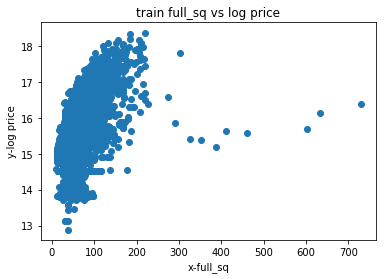

In [20]:
# ylog1p_train

# scatter full_sq vs log_price with outliers
plt.scatter(sberbank_train['full_sq'], ylog1p_train)
plt.title("train full_sq vs log price")
plt.xlabel("x-full_sq")
plt.ylabel("y-log price")
plt.show()


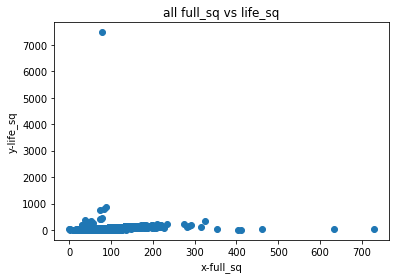

In [21]:
# scatter full_sq vs lif_sq with outliers
plt.scatter(sberbank_all['full_sq'], sberbank_all['life_sq'])
plt.title("all full_sq vs life_sq")
plt.xlabel("x-full_sq")
plt.ylabel("y-life_sq")
plt.show()

In [22]:
# down_quantiles = df_all['full_sq'].quantile(0.05)
# # Up_que_full_sq = df_all['full_sq'].percentile(0.001)

# df.loc[df['y'] == 'N/A','y'] = np.nan
#df_train.loc[df_train['full_sq'] >250 ,'full_sq'] = np.nan
#df_train.loc[df_train['life_sq'] >250 ,'life_sq'] = np.nan
sberbank_all_tmp.loc[sberbank_all_tmp['full_sq'] <1.5 ,'full_sq'] = np.nan
sberbank_all_tmp.loc[sberbank_all_tmp['life_sq'] <1.5 ,'life_sq'] = np.nan
#df_train.loc[df_train['full_sq'] <1.5 ,'full_sq'] = np.nan
#df_train.loc[df_train['life_sq'] <1.5 ,'life_sq'] = np.nan
sberbank_all_tmp.loc[sberbank_all_tmp['full_sq'] >250 ,'full_sq'] = np.nan
sberbank_all_tmp.loc[sberbank_all_tmp['life_sq'] >250 ,'life_sq'] = np.nan
sberbank_all_tmp.loc[sberbank_all_tmp['floor'] >50 ,'floor'] = np.nan

In [23]:
sberbank_all_tmp.loc[sberbank_all_tmp['full_sq'] >250]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,...,cafe_count_3000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,source,year,month,q,ylog1p_doc,DayNumeric,WeekDay1,WeekDay2,timedelta
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


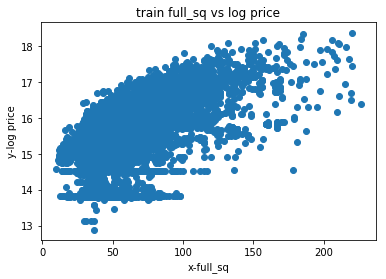

In [24]:
# scatter full_sq vs log_price without outliers
plt.scatter(sberbank_all_tmp.loc[sberbank_all_tmp['source']=='train','full_sq'], ylog1p_train)
plt.title("train full_sq vs log price")
plt.xlabel("x-full_sq")
plt.ylabel("y-log price")
plt.show()


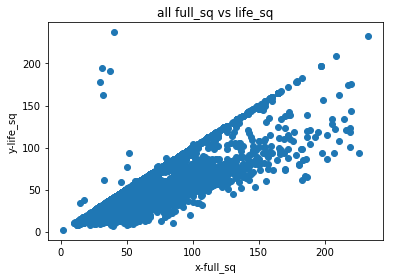

In [25]:
# scatter full_sq vs life_sq without outliers
plt.scatter(sberbank_all_tmp['full_sq'], sberbank_all_tmp['life_sq'])
plt.title("all full_sq vs life_sq")
plt.xlabel("x-full_sq")
plt.ylabel("y-life_sq")
plt.show()

[Text(0,0.5,u'floor'),
 Text(0.5,0,u'source'),
 Text(0.5,1,u'Box Plot floor  Across trainOrTest')]

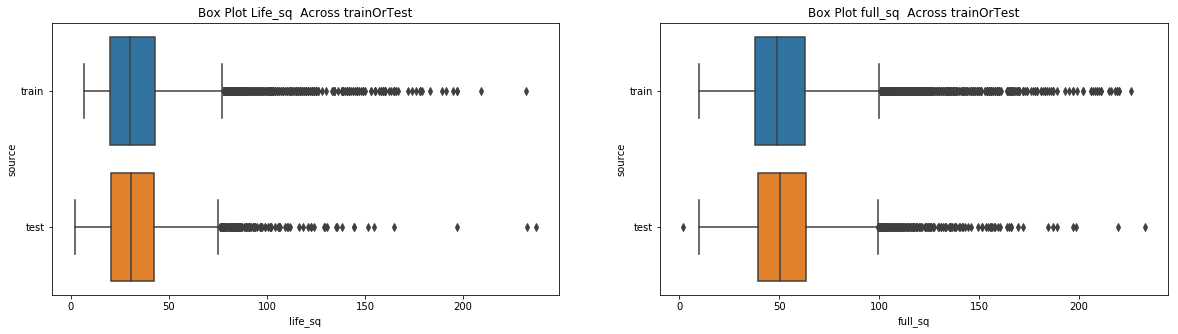

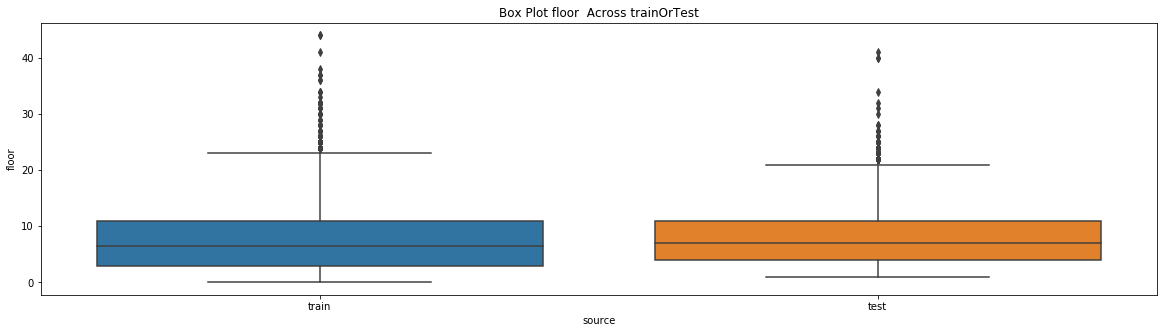

In [26]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20,5)
# sn.boxplot(data=train_df,y="Log10Price",orient="v",ax=ax1)
sn.boxplot(data=sberbank_all_tmp,x="life_sq",y="source",orient="h",ax=ax1)
sn.boxplot(data=sberbank_all_tmp,x="full_sq",y="source",orient="h",ax=ax2)

fig1,ax3 = plt.subplots()
fig1.set_size_inches(20,5)
sn.boxplot(data=sberbank_all_tmp,x="source",y="floor",orient="v",ax=ax3)
# ax1.set(ylabel='Log10Price',title="Box Plot On Log10 Price by Week day ")
ax1.set(xlabel='life_sq', ylabel='source',title="Box Plot Life_sq  Across trainOrTest")
ax2.set(xlabel='full_sq', ylabel='source',title="Box Plot full_sq  Across trainOrTest")
ax3.set(xlabel='source', ylabel='floor',title="Box Plot floor  Across trainOrTest")

**----------  End of EDA  ------------**

# Preparing the data for the ML Model

**----------  Clean Data------------**

In [27]:
bad_index1 = sberbank_all[sberbank_all.full_sq < 5].index
sberbank_all.loc[bad_index1, 'full_sq'] = sberbank_all.loc[bad_index1, 'life_sq']

bad_index2=sberbank_all[sberbank_all.life_sq > sberbank_all.full_sq].index
sberbank_all.loc[bad_index2, 'life_sq'] = np.NaN

bad_index3 = sberbank_all[sberbank_all.life_sq < 5].index
sberbank_all.loc[bad_index3, 'life_sq'] = np.NaN

bad_index4 = sberbank_all[sberbank_all.kitch_sq >= sberbank_all.life_sq].index
sberbank_all.loc[bad_index4, 'kitch_sq'] = np.NaN

bad_index5 = sberbank_all[(sberbank_all.kitch_sq == 0).values + (sberbank_all.kitch_sq == 1).values].index
sberbank_all.loc[bad_index5, 'kitch_sq'] = np.NaN

bad_index6 = sberbank_all[sberbank_all.state == 33].index
sberbank_all.loc[bad_index6, 'state'] = np.NaN

bad_index7 = sberbank_all[(sberbank_all.build_year < 1500).values + (sberbank_all.build_year > 3000).values].index
sberbank_all.loc[bad_index7, 'build_year'] = np.NaN

In [28]:
sberbank_all['full_sq'].isnull().sum()

0

In [29]:
# Magic_Numbers

rate_2015_q2 = 1
rate_2015_q1 = rate_2015_q2 / 0.9932

rate_2014_q4 = rate_2015_q1 / 1.0112
rate_2014_q3 = rate_2014_q4 / 1.0169
rate_2014_q2 = rate_2014_q3 / 1.0086
rate_2014_q1 = rate_2014_q2 / 1.0126 

rate_2013_q4 = rate_2014_q1 / 0.9902 
rate_2013_q3 = rate_2013_q4 / 1.0041 
rate_2013_q2 = rate_2013_q3 / 1.0044 
rate_2013_q1 = rate_2013_q2 / 1.0104 

rate_2012_q4 = rate_2013_q1 / 0.9832 
rate_2012_q3 = rate_2012_q4 / 1.0277
rate_2012_q2 = rate_2012_q3 / 1.0279 
rate_2012_q1 = rate_2012_q2 / 1.0279 

rate_2011_q4 = rate_2012_q1 / 1.076
rate_2011_q3 = rate_2011_q4 / 1.0236 
rate_2011_q2 = rate_2011_q3 / 1.01 
rate_2011_q1 = rate_2011_q2 / 1.011 

rate_2015_q3 = rate_2015_q2 * 0.9815 
rate_2015_q4 = rate_2015_q3 * 0.9834

rate_2016_q1 = rate_2015_q4 * 0.9831
rate_2016_q2 = rate_2016_q1 * 0.99903


In [30]:
#**
rate_2016_q2

0.9479746717629903

In [31]:
#**
price = 100
price_2016_q2=price*rate_2016_q2
print price_2016_q2

price_2015_q2=price/rate_2015_q2
print price_2015_q2

price_2011_q1=price/rate_2011_q1
print price_2011_q1

94.7974671763
100
126.367057564


In [32]:
#**
price_2015_q1=price/rate_2015_q1
price_2015_q3=price*rate_2015_q3
price_2015_q4=price*rate_2015_q4

print price_2015_q1
print price_2015_q3
print price_2015_q4

99.32
98.15
96.52071


In [33]:
# Add computed columns Q_Rate , Price_New , ylog1p_new
conditions = [

    (sberbank_all['year'] == 2016) & (sberbank_all['q'] == 2),
    (sberbank_all['year'] == 2016) & (sberbank_all['q'] == 1),
    
    (sberbank_all['year'] == 2015) & (sberbank_all['q'] == 4),
    (sberbank_all['year'] == 2015) & (sberbank_all['q'] == 3),
    
    (sberbank_all['year'] == 2015) & (sberbank_all['q'] == 2),
    (sberbank_all['year'] == 2015) & (sberbank_all['q'] == 1),
    
    (sberbank_all['year'] == 2014) & (sberbank_all['q'] == 4),
    (sberbank_all['year'] == 2014) & (sberbank_all['q'] == 3),
    (sberbank_all['year'] == 2014) & (sberbank_all['q'] == 2),
    (sberbank_all['year'] == 2014) & (sberbank_all['q'] == 1),

    (sberbank_all['year'] == 2013) & (sberbank_all['q'] == 4),
    (sberbank_all['year'] == 2013) & (sberbank_all['q'] == 3),
    (sberbank_all['year'] == 2013) & (sberbank_all['q'] == 2),
    (sberbank_all['year'] == 2013) & (sberbank_all['q'] == 1),

    (sberbank_all['year'] == 2012) & (sberbank_all['q'] == 4),
    (sberbank_all['year'] == 2012) & (sberbank_all['q'] == 3),
    (sberbank_all['year'] == 2012) & (sberbank_all['q'] == 2),
    (sberbank_all['year'] == 2012) & (sberbank_all['q'] == 1),

    (sberbank_all['year'] == 2011) & (sberbank_all['q'] == 4),
    (sberbank_all['year'] == 2011) & (sberbank_all['q'] == 3),
    (sberbank_all['year'] == 2011) & (sberbank_all['q'] == 2),
    (sberbank_all['year'] == 2011) & (sberbank_all['q'] == 1)]  

choices = [rate_2016_q2, rate_2016_q1,
           rate_2015_q4, rate_2015_q3, rate_2015_q2, rate_2015_q1, rate_2014_q4, rate_2014_q3,rate_2014_q2,rate_2014_q1,
           rate_2013_q4, rate_2013_q3,rate_2013_q2,rate_2013_q1, rate_2012_q4, rate_2012_q3,rate_2012_q2,rate_2012_q1,
           rate_2011_q4, rate_2011_q3,rate_2011_q2,rate_2011_q1]
           
sberbank_all['q_rate'] = np.select(conditions, choices)
sberbank_all['price_new'] = (sberbank_all['price_doc']/sberbank_all['q_rate']).astype(int)
sberbank_all['ylog1p_new'] = np.log1p(sberbank_all['price_new'].values)

In [34]:

# Converting yes/no columns into 0/1

sberbank_all['culture_objects_top_25']=np.where(sberbank_all['culture_objects_top_25']=='no',0,1)
sberbank_all['thermal_power_plant_raion']=np.where(sberbank_all['thermal_power_plant_raion']=='no',0,1)
sberbank_all['incineration_raion']=np.where(sberbank_all['incineration_raion']=='no',0,1)
sberbank_all['oil_chemistry_raion']=np.where(sberbank_all['oil_chemistry_raion']=='no',0,1)
sberbank_all['radiation_raion']=np.where(sberbank_all['radiation_raion']=='no',0,1)
sberbank_all['railroad_terminal_raion']=np.where(sberbank_all['railroad_terminal_raion']=='no',0,1)
sberbank_all['big_market_raion']=np.where(sberbank_all['big_market_raion']=='no',0,1)
sberbank_all['nuclear_reactor_raion']=np.where(sberbank_all['nuclear_reactor_raion']=='no',0,1)
sberbank_all['detention_facility_raion']=np.where(sberbank_all['detention_facility_raion']=='no',0,1)
sberbank_all['water_1line']=np.where(sberbank_all['water_1line']=='no',0,1)
sberbank_all['big_road1_1line']=np.where(sberbank_all['big_road1_1line']=='no',0,1)
sberbank_all['railroad_1line']=np.where(sberbank_all['railroad_1line']=='no',0,1)


In [35]:
sberbank_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38066 entries, 1 to 38135
Columns: 299 entries, timestamp to ylog1p_new
dtypes: datetime64[ns](1), float64(124), int32(13), int64(157), object(4)
memory usage: 86.5+ MB


**----------  Filling NA's / Changing to propotion / Droping------------**

In [36]:
# Life_sq Fill Null's

In [36]:
# Fined the average proprtion of the life_sq from full_sq
df_tmp0=sberbank_all.loc[(sberbank_all['life_sq'].isnull()==False) & (sberbank_all['life_sq']<sberbank_all['full_sq']),['full_sq','life_sq']]
df_tmp0['prop']=(df_tmp0['life_sq']/df_tmp0['full_sq'] )
life_sq_prop=df_tmp0['prop'].mean()
life_sq_prop

0.5951284344406517

In [37]:
# Fined the average proprtion of the kitch_sq from full_sq
df_tmp0=sberbank_all.loc[(sberbank_all['kitch_sq'].isnull()==False) & (sberbank_all['kitch_sq']<sberbank_all['full_sq']),['full_sq','kitch_sq']]
df_tmp0['prop']=(df_tmp0['kitch_sq']/df_tmp0['full_sq'] )
kitch_sq_prop=df_tmp0['prop'].mean()
kitch_sq_prop

0.16354092962509623

In [38]:
sberbank_all_fillNa=sberbank_all.copy()

In [39]:
sberbank_all_fillNa['life_sq'].fillna(value=(sberbank_all_fillNa['full_sq']*life_sq_prop).astype(int),inplace=True)
sberbank_all_fillNa['kitch_sq'].fillna(value=(sberbank_all_fillNa['full_sq']*kitch_sq_prop).astype(int),inplace=True)
sberbank_all_fillNa['floor'].fillna(value=0,inplace=True)
sberbank_all_fillNa['max_floor'].fillna(sberbank_all_fillNa.groupby('sub_area')['max_floor'].transform('mean').astype(int),inplace=True)
sberbank_all_fillNa['build_year'].fillna(sberbank_all_fillNa.groupby('sub_area')['build_year'].transform('median').astype(int),inplace=True)
sberbank_all_fillNa['state'].fillna(sberbank_all_fillNa.groupby('sub_area')['state'].transform('median'),inplace=True)
sberbank_all_fillNa['material'].fillna(sberbank_all_fillNa.groupby('sub_area')['material'].transform('median'),inplace=True)

In [40]:
sberbank_all_fillNa.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,...,trc_sqm_3000,cafe_count_3000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,source,year,month,q,ylog1p_doc,q_rate,price_new,ylog1p_new
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43.0,27.0,4.0,12.0,1.0,1977.0,NaN,7.0,2.0,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,9576,5001.0,5,10309,11065.0,5,0,240.0,1,0,7,3,0,0,16,1,0,0,0,0,0,0,0,0,86206,40477,45729,21154,11007,10147,98207,52277,45930,36211,...,1419204,68,639.68,1079.37,859.52,5,21,22,16,3,1,0,2,4,0,0,21,1,13.09,13.31,29,807385,52,4036616,152,708.57,1185.71,947.14,12,39,48,40,9,4,0,13,22,1,0,52,4,5850000.0,train,2011,8,3,15.581952,0.808051,7239643,15.795083
2,2011-08-23,34.0,19.0,3.0,17.0,4.0,2016.0,NaN,5.0,1.0,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,6880,3119.0,5,7759,6237.0,8,0,229.0,1,0,6,1,1,1,3,0,0,0,0,0,0,0,0,0,76284,34200,42084,15727,7925,7802,70194,35622,34572,29431,...,491565,30,631.03,1086.21,858.62,1,11,11,4,2,1,0,1,7,0,6,19,1,10.26,27.47,66,2690465,40,2034942,177,673.81,1148.81,911.31,9,49,65,36,15,3,0,15,29,1,10,66,14,6000000.0,train,2011,8,3,15.607270,0.808051,7425275,15.820400
3,2011-08-27,43.0,29.0,2.0,11.0,1.0,1969.0,NaN,7.0,2.0,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,5879,1463.0,4,6207,5580.0,7,0,1183.0,1,0,5,1,0,0,0,1,0,0,0,1,0,0,0,0,101982,46076,55906,13028,6835,6193,63388,31813,31575,25292,...,52550,41,697.44,1192.31,944.87,2,9,17,9,3,1,0,0,11,0,0,20,6,13.69,21.58,43,1478160,35,1572990,122,702.68,1196.43,949.55,10,29,45,25,10,3,0,11,27,0,4,67,10,5700000.0,train,2011,8,3,15.555977,0.808051,7054012,15.769107
4,2011-09-01,89.0,50.0,9.0,16.0,1.0,2002.0,NaN,14.0,2.0,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,13087,6839.0,9,13670,17063.0,10,0,NaN,1,0,17,6,0,0,11,4,0,0,0,0,0,0,0,0,21155,9828,11327,28563,14680,13883,120381,60040,60341,29529,...,205756,32,718.75,1218.75,968.75,0,5,14,10,3,0,0,1,2,0,0,18,3,14.18,3.89,8,244166,22,942180,61,931.58,1552.63,1242.11,4,7,21,15,11,2,1,4,4,0,0,26,3,13100000.0,train,2011,9,3,16.388123,0.808051,16211852,16.601253
5,2011-09-05,77.0,77.0,4.0,7.0,2.0,1964.0,NaN,12.0,2.0,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,5706,3240.0,7,6748,7770.0,9,0,562.0,4,2,25,2,0,0,10,93,0,0,0,1,1,0,0,0,28179,13522,14657,13368,7159,6209,68043,34236,33807,26760,...,2296870,1068,853.03,1410.45,1131

In [49]:
# Raion data Fill Null's

In [41]:
sberbank_all_fillNa['preschool_quota'].fillna(value=0,inplace=True)
sberbank_all_fillNa['school_quota'].fillna(value=0,inplace=True)
sberbank_all_fillNa['hospital_beds_raion'].fillna(value=0,inplace=True)

sberbank_all_fillNa['raion_build_count_with_material_info'].fillna(value=0,inplace=True)
sberbank_all_fillNa['build_count_block'].fillna(value=0,inplace=True)
sberbank_all_fillNa['build_count_wood'].fillna(value=0,inplace=True)
sberbank_all_fillNa['build_count_frame'].fillna(value=0,inplace=True)
sberbank_all_fillNa['build_count_brick'].fillna(value=0,inplace=True)
sberbank_all_fillNa['build_count_panel'].fillna(value=0,inplace=True)
sberbank_all_fillNa['build_count_foam'].fillna(value=0,inplace=True)
sberbank_all_fillNa['build_count_slag'].fillna(value=0,inplace=True)
sberbank_all_fillNa['build_count_mix'].fillna(value=0,inplace=True)

sberbank_all_fillNa['raion_build_count_with_builddate_info'].fillna(value=0,inplace=True)
sberbank_all_fillNa['build_count_before_1920'].fillna(value=0,inplace=True)
sberbank_all_fillNa['build_count_1921-1945'].fillna(value=0,inplace=True)
sberbank_all_fillNa['build_count_1946-1970'].fillna(value=0,inplace=True)
sberbank_all_fillNa['build_count_1971-1995'].fillna(value=0,inplace=True)
sberbank_all_fillNa['build_count_after_1995'].fillna(value=0,inplace=True)


In [51]:
# Build proportion fields

In [52]:
#sberbank_all_fillNa_a=sberbank_all_fillNa.copy()

In [42]:
sberbank_all_fillNa['children_preschool_p']=(sberbank_all_fillNa['children_preschool']/sberbank_all_fillNa['raion_popul']).round(2)
sberbank_all_fillNa['preschool_quota_p']=(sberbank_all_fillNa['preschool_quota']/sberbank_all_fillNa['children_preschool']).round(2)
sberbank_all_fillNa['preschool_education_centers_raion_p']=(sberbank_all_fillNa['preschool_education_centers_raion']/sberbank_all_fillNa['children_preschool']).round(2)

sberbank_all_fillNa['children_school_p']=(sberbank_all_fillNa['children_school']/sberbank_all_fillNa['raion_popul']).round(2)
sberbank_all_fillNa['school_quota_p']=(sberbank_all_fillNa['school_quota']/sberbank_all_fillNa['children_school']).round(2)
sberbank_all_fillNa['school_education_centers_raion_p']=(sberbank_all_fillNa['school_education_centers_raion']).round(2)

sberbank_all_fillNa['hospital_beds_raion_p']=(sberbank_all_fillNa['hospital_beds_raion']/sberbank_all_fillNa['raion_popul']).round(2)
sberbank_all_fillNa['healthcare_centers_raion_p']=(sberbank_all_fillNa['healthcare_centers_raion']/sberbank_all_fillNa['raion_popul']).round(2)
sberbank_all_fillNa['shopping_centers_raion_p']=(sberbank_all_fillNa['children_school']/sberbank_all_fillNa['raion_popul']).round(2)

sberbank_all_fillNa['male_f_p']=(sberbank_all_fillNa['male_f']/sberbank_all_fillNa['full_all']).round(2)
sberbank_all_fillNa['female_p']=(sberbank_all_fillNa['female_f']/sberbank_all_fillNa['full_all']).round(2)

sberbank_all_fillNa['young_all_p']=(sberbank_all_fillNa['young_all']/sberbank_all_fillNa['raion_popul']).round(2)
sberbank_all_fillNa['work_all_p']=(sberbank_all_fillNa['work_all']/sberbank_all_fillNa['raion_popul']).round(2)
sberbank_all_fillNa['ekder_all_all_p']=(sberbank_all_fillNa['ekder_all']/sberbank_all_fillNa['raion_popul']).round(2)

sberbank_all_fillNa['build_count_block_p']=(sberbank_all_fillNa['build_count_block']/sberbank_all_fillNa['raion_build_count_with_material_info']).round(2)
sberbank_all_fillNa['build_count_wood_p']=(sberbank_all_fillNa['build_count_wood']/sberbank_all_fillNa['raion_build_count_with_material_info']).round(2)
sberbank_all_fillNa['build_count_frame_p']=(sberbank_all_fillNa['build_count_frame']/sberbank_all_fillNa['raion_build_count_with_material_info']).round(2)
sberbank_all_fillNa['build_count_brick_p']=(sberbank_all_fillNa['build_count_brick']/sberbank_all_fillNa['raion_build_count_with_material_info']).round(2)
sberbank_all_fillNa['build_count_panel_p']=(sberbank_all_fillNa['build_count_panel']/sberbank_all_fillNa['raion_build_count_with_material_info']).round(2)
sberbank_all_fillNa['build_count_foam_p']=(sberbank_all_fillNa['build_count_foam']/sberbank_all_fillNa['raion_build_count_with_material_info']).round(2)
sberbank_all_fillNa['build_count_slag_p']=(sberbank_all_fillNa['build_count_slag']/sberbank_all_fillNa['raion_build_count_with_material_info']).round(2)
sberbank_all_fillNa['build_count_mix_p']=(sberbank_all_fillNa['build_count_mix']/sberbank_all_fillNa['raion_build_count_with_material_info']).round(2)

sberbank_all_fillNa['build_count_before_1920_p']=(sberbank_all_fillNa['build_count_before_1920']/sberbank_all_fillNa['raion_build_count_with_builddate_info']).round(2)
sberbank_all_fillNa['build_count_1921-1945_p']=(sberbank_all_fillNa['build_count_1921-1945']/sberbank_all_fillNa['raion_build_count_with_builddate_info']).round(2)
sberbank_all_fillNa['build_count_1946-1970_p']=(sberbank_all_fillNa['build_count_1946-1970']/sberbank_all_fillNa['raion_build_count_with_builddate_info']).round(2)
sberbank_all_fillNa['build_count_1971-1995_p']=(sberbank_all_fillNa['build_count_1971-1995']/sberbank_all_fillNa['raion_build_count_with_builddate_info']).round(2)
sberbank_all_fillNa['build_count_after_1995_p']=(sberbank_all_fillNa['build_count_after_1995']/sberbank_all_fillNa['raion_build_count_with_builddate_info']).round(2)


C:\Users\Hanan\Anaconda2\lib\site-packages\pandas\core\series.py:1295: RuntimeWarning: invalid value encountered in rint
  result = _values_from_object(self).round(decimals)


In [ ]:
# Drop Columns

In [43]:
sberbank_all_fillNa.drop(['raion_popul','children_preschool','preschool_quota','preschool_education_centers_raion'
                         ,'children_school','school_quota','school_education_centers_raion'
                         ,'hospital_beds_raion','healthcare_centers_raion','shopping_centers_raion'
                         ,'full_all','male_f','female_f','young_all','young_male','young_female'
                         ,'work_all','work_male','work_female','ekder_all','ekder_male','ekder_female'
                         ,'0_6_all','0_6_male','0_6_female','7_14_all','7_14_male','7_14_female','0_17_all'
                         ,'0_17_male','0_17_female','16_29_all','16_29_male','16_29_female','0_13_all'
                         ,'0_13_male','0_13_female'],axis=1,inplace=True)

sberbank_all_fillNa.drop(['raion_build_count_with_material_info','build_count_block','build_count_wood','build_count_frame'
                         ,'build_count_brick','build_count_panel','build_count_foam'
                         ,'build_count_slag','build_count_mix'],axis=1,inplace=True)

sberbank_all_fillNa.drop(['raion_build_count_with_builddate_info','build_count_1921-1945','build_count_1946-1970'
                         ,'build_count_1971-1995','build_count_after_1995'],axis=1,inplace=True)

sberbank_all_fillNa.drop(['ID_metro','ID_railroad_station_walk','ID_railroad_station_avto'
                        ,'ID_big_road1','ID_big_road2','ID_railroad_terminal','ID_bus_terminal'],axis=1,inplace=True)


In [ ]:
##sberbank_all_fillNa['build_count_1971-1995'].isnull().sum()

In [44]:
sberbank_all_fillNa[['sub_area','build_count_slag_p','source']].head()

,sub_area,build_count_slag_p,source
id,,,
1,Bibirevo,0.00,train
2,Nagatinskij Zaton,0.00,train
3,Tekstil'shhiki,0.00,train
4,Mitino,0.02,train
5,Basmannoe,0.00,train


In [45]:
sberbank_all_fillNa.columns[118:130]

Index([u'prom_part_1000', u'office_count_1000', u'office_sqm_1000',
       u'trc_count_1000', u'trc_sqm_1000', u'cafe_count_1000',
       u'cafe_sum_1000_min_price_avg', u'cafe_sum_1000_max_price_avg',
       u'cafe_avg_price_1000', u'cafe_count_1000_na_price',
       u'cafe_count_1000_price_500', u'cafe_count_1000_price_1000'],
      dtype='object')

In [46]:
sberbank_all_fillNa.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,green_zone_part,indust_part,school_education_centers_top_20_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,build_count_monolith,build_count_before_1920,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,...,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,source,year,month,q,ylog1p_doc,q_rate,price_new,ylog1p_new,children_preschool_p,preschool_quota_p,preschool_education_centers_raion_p,children_school_p,school_quota_p,school_education_centers_raion_p,hospital_beds_raion_p,healthcare_centers_raion_p,shopping_centers_raion_p,male_f_p,female_p,young_all_p,work_all_p,ekder_all_all_p,build_count_block_p,build_count_wood_p,build_count_frame_p,build_count_brick_p,build_count_panel_p,build_count_foam_p,build_count_slag_p,build_count_mix_p,build_count_before_1920_p,build_count_1921-1945_p,build_count_1946-1970_p,build_count_1971-1995_p,build_count_after_1995_p
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43.0,27.0,4.0,12.0,1.0,1977.0,NaN,7.0,2.0,Investment,Bibirevo,6.407578e+06,0.189727,0.000070,0,0,7,3,0,0,1,0,0,0,0,0,0,0,0,2.0,0.0,2.590241,1.131260,13.575119,1.131260,0.145700,0.177975,2.158587,0.600973,1.080934,23.683460,1.804127,3.633334,5.419893,65.038716,5.419893,6.905893,0.274985,3.299822,...,947.14,12,39,48,40,9,4,0,13,22,1,0,52,4,5850000.0,train,2011,8,3,15.581952,0.808051,7239643,15.795083,0.06,0.52,0.0,0.07,1.07,5,0.00,0.0,0.07,0.47,0.53,0.14,0.63,0.23,0.12,0.00,0.00,0.00,0.87,0.0,0.00,0.0,0.00,0.00,0.00,0.98,0.02
2,2011-08-23,34.0,19.0,3.0,17.0,4.0,2016.0,NaN,5.0,1.0,Investment,Nagatinskij Zaton,9.589337e+06,0.372602,0.049637,0,0,6,1,1,1,0,0,0,0,0,0,0,0,0,4.0,1.0,0.936700,0.647337,7.620630,0.635053,0.147754,0.273345,0.550690,0.065321,0.966479,1.317476,4.655004,8.648587,3.411993,40.943917,3.641773,4.679745,0.065263,0.783160,...,911.31,9,49,65,36,15,3,0,15,29,1,10,66,14,6000000.0,train,2011,8,3,15.607270,0.808051,7425275,15.820400,0.06,0.45,0.0,0.07,0.80,8,0.00,0.0,0.07,0.45,0.55,0.14,0.61,0.26,0.34,0.00,0.00,0.27,0.37,0.0,0.00,0.0,0.00,0.00,0.59,0.34,0.06
3,2011-08-27,43.0,29.0,2.0,11.0,1.0,1969.0,NaN,7.0,2.0,Investment,Tekstil'shhiki,4.808270e+06,0.112560,0.118537,0,0,5,1,0,0,1,0,0,0,1,0,0,0,0,4.0,1.0,2.120999,1.637996,17.351515,1.445960,0.049102,0.158072,0.374848,0.453172,0.939275,4.912660,3.381083,11.996480,1.277658,15.331896,1.277658,1.701420,0.328756,3.945073,...,949.55,10,29,45,25,10,3,0,11,27,0,4,67,10,5700000.0,train,2011,8,3,15.555977,0.808051,7054012,15.769107,0.06,0.25,0.0,0.06,0.90,7,0.01,0.0,0.06,0.45,0.55,0.13,0.62,0.25,0.18,0.00,0.00,0.62,0.18,0.0,0.00,0.0,0.00,0.00,0.75,0.19,0.06
4,2011-09-01,89.0,50.0,9.0,16.0,1.0,2002.0,NaN,14.0,2.0,Investment,Mitino,1.258354e+07,0.194703,0.069753,0,0,17,6,0,0,4,0,0,0,0,0,0,0,0,50.0,13.0,1.489049,0.984537,11.565624,0.963802,0.179441,0.236455,0.078090,0.106125,0.451173,15.623710,2.017080,14.317640,4.291432,51.497190,3.816045,5.271136,0.131597,1.579164,...,1242.11,4,7,21,15,11,2,1,4,4,0,0,26,3,13100000.0,train,2011,9,3,16.388123,0.808051,16211852,16.601253,0.07,0.52,0.0,0.08,1.25,10,0

In [58]:
# https://chrisalbon.com/python/data_wrangling/pandas_missing_data/

In [59]:
#sberbank_all_fillNa['shopping_centers_raion'].isnull().sum()

**----------  Dealing with Object columns  ------------**

In [47]:
# get_dummies
sberbank_all1 = pd.get_dummies(sberbank_all_fillNa, columns=['product_type','sub_area'])


In [48]:
# Converting all Object columns into Int

for c in sberbank_all1.columns:
    if sberbank_all1[c].dtype == 'object':
        print c
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(sberbank_all1[c].values))
        sberbank_all1[c] = lbl.transform(list(sberbank_all1[c].values))


ecology
source


In [49]:
sberbank_all1.tail()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,green_zone_part,indust_part,school_education_centers_top_20_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,build_count_monolith,build_count_before_1920,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,...,sub_area_Poselenie Novofedorovskoe,sub_area_Poselenie Pervomajskoe,sub_area_Poselenie Rjazanovskoe,sub_area_Poselenie Rogovskoe,sub_area_Poselenie Shhapovskoe,sub_area_Poselenie Shherbinka,sub_area_Poselenie Sosenskoe,sub_area_Poselenie Vnukovskoe,sub_area_Poselenie Voronovskoe,sub_area_Poselenie Voskresenskoe,sub_area_Preobrazhenskoe,sub_area_Presnenskoe,sub_area_Prospekt Vernadskogo,sub_area_Ramenki,sub_area_Rjazanskij,sub_area_Rostokino,sub_area_Savelki,sub_area_Savelovskoe,sub_area_Severnoe,sub_area_Severnoe Butovo,sub_area_Severnoe Izmajlovo,sub_area_Severnoe Medvedkovo,sub_area_Severnoe Tushino,sub_area_Shhukino,sub_area_Silino,sub_area_Sokol,sub_area_Sokol'niki,sub_area_Sokolinaja Gora,sub_area_Solncevo,sub_area_Staroe Krjukovo,sub_area_Strogino,sub_area_Sviblovo,sub_area_Taganskoe,sub_area_Tekstil'shhiki,sub_area_Teplyj Stan,sub_area_Timirjazevskoe,sub_area_Troickij okrug,sub_area_Troparevo-Nikulino,sub_area_Tverskoe,sub_area_Veshnjaki,sub_area_Vnukovo,sub_area_Vojkovskoe,sub_area_Vostochnoe,sub_area_Vostochnoe Degunino,sub_area_Vostochnoe Izmajlovo,sub_area_Vyhino-Zhulebino,sub_area_Zamoskvorech'e,sub_area_Zapadnoe Degunino,sub_area_Zjablikovo,sub_area_Zjuzino
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
38131,2016-05-26,52.20,31.8,10.0,12.0,5.0,1973.0,2.0,9.1,2.0,7.811375e+06,0.127002,0.135650,0,0,11,3,0,0,6,0,0,0,1,0,0,0,0,3.0,0.0,1.789207,1.179312,13.968183,1.164015,0.334653,0.413881,2.985011,0.199909,0.624466,8.841655,4.452060,7.347121,8.989496,107.873950,9.046194,11.649396,0.069066,0.828790,0.219356,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
38132,2016-05-28,54.09,32.0,14.0,0.0,1.0,2015.0,2.0,8.0,1.0,5.299528e+07,0.349935,0.011654,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,15.839451,12.718568,144.236338,12.019695,4.415205,7.671322,9.684197,0.991824,1.351922,9.211348,1.252875,18.367510,18.449574,221.394885,21.279217,21.765343,1.791212,21.494546,0.215268,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
38133,2016-05-30,41.08,24.0,12.0,1.0,1.0,2014.0,1.0,6.0,1.0,7.307411e+06,0.065444,0.000078,1,2,29,16,1,10,141,0,0,0,1,1,0,0,1,25.0,263.0,1.482746,1.036568,13.459068,1.121589,1.048962,0.269716,0.284300,0.189089,2.640803,10.378040,4.242627,12.180740,3.378717,40.544603,4.060430,5.143798,0.326035,3.912418,0.524839,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
38134,2016-05-30,34.80,19.8,8.0,9.0,5.0,1977.0,1.0,6.4,2.0,7.128794e+06,0.075790,0.100456,1,0,7,2,0,0,0,0,0,0,0,0,1,0,0,3.0,0.0,1.469263,0.930198,11.162378,0.930198,0.073023,0.208540,2.950264,0.766444,0.521349,5.611768,1.856325,5.667783,5.018911,60.226932,4.766769,6.164570,0.116044,1.392524,1.394677,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
38135,2016-05-30,63.00,43.8,5.0,5.0,1.0,1973.0,3.0,7.1,3.0,6.206099e+06,0.128123,0.089040,0,0,10,3,0,0,5,0,0,0,0,0,0,0,0,3.0,0.0,2.974336,1.172278,14.067336,1.172278,0.179474,0.498553,3.0

**----------  Dealing with Left Missing/NA values  ------------**

In [ ]:
# Dumm Fill NA
#sberbank_all1=sberbank_all1.fillna(0)
#sberbank_all1.isnull().sum(axis=0)

In [50]:
# Create a list of columns that have missing values and an index (True / False)

df_missing = sberbank_all1.isnull().sum(axis = 0).reset_index()
df_missing.columns = ['column_name', 'missing_count']
idx_ = df_missing['missing_count'] > 0
df_missing = df_missing.loc[idx_]
cols_missing = df_missing.column_name.values
idx_cols_missing = sberbank_all1.columns.isin(cols_missing)

In [51]:
df_missing.head(15)

,column_name,missing_count
7,num_room,9540
9,state,1
28,build_count_monolith,6202
32,metro_min_walk,59
33,metro_km_walk,59
42,railroad_station_walk_km,59
43,railroad_station_walk_min,59
99,cafe_sum_500_min_price_avg,16410
100,cafe_sum_500_max_price_avg,16410
101,cafe_avg_price_500,16410


In [52]:
# Instantiate an imputer
imputer = preprocessing.Imputer(missing_values='NaN', strategy = 'most_frequent', axis = 0)

# Fit the imputer using all of our data (but not any dates)
imputer.fit(sberbank_all1.loc[:, idx_cols_missing])

# Apply the imputer
sberbank_all1.loc[:, idx_cols_missing] = imputer.transform(sberbank_all1.loc[:, idx_cols_missing])

In [53]:
sberbank_all1.isnull().sum().head()

timestamp    0
full_sq      0
life_sq      0
floor        0
max_floor    0
dtype: int64

In [54]:
#**
sberbank_all1['price_doc'].head()

id
1     5850000.0
2     6000000.0
3     5700000.0
4    13100000.0
5    16331452.0
Name: price_doc, dtype: float64

In [55]:
#**
sberbank_all1['ylog1p_doc'].head()

id
1    15.581952
2    15.607270
3    15.555977
4    16.388123
5    16.608603
Name: ylog1p_doc, dtype: float64

In [56]:
#**
sberbank_all1['price_new'].head()

id
1     7239643
2     7425275
3     7054012
4    16211852
5    20210922
Name: price_new, dtype: int32

In [57]:
#**
tmp=(np.exp(sberbank_all1['ylog1p_doc']) - 1)
tmp.head()
#y_pred = (np.exp(y_train) - 1)

id
1     5850000.0
2     6000000.0
3     5700000.0
4    13100000.0
5    16331452.0
Name: ylog1p_doc, dtype: float64

**--------  Prepare separate train and test datasets ------------**

In [ ]:

#idx_train = sberbank_all1['source'] == 1
#idx_test = sberbank_all1['source'] == 0

#X_train = sberbank_all1[idx_train]
#X_test = sberbank_all1[idx_test]

In [58]:
train=sberbank_all1[sberbank_all1['source']==1]
test=sberbank_all1[sberbank_all1['source']==0]

drop_cols=['timestamp','price_doc','price_new','ylog1p_doc','ylog1p_new','year','month','q','q_rate','source']

In [59]:
X_train=train.drop(drop_cols,axis=1)

#y_train=train['price_doc']
y_train=train['price_new']

#y_train=train['ylog1p_doc']
#y_train=train['ylog1p_new']

X_test=test.drop(drop_cols,axis=1)

In [60]:
X_test.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,green_zone_part,indust_part,school_education_centers_top_20_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,build_count_monolith,build_count_before_1920,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,...,sub_area_Poselenie Novofedorovskoe,sub_area_Poselenie Pervomajskoe,sub_area_Poselenie Rjazanovskoe,sub_area_Poselenie Rogovskoe,sub_area_Poselenie Shhapovskoe,sub_area_Poselenie Shherbinka,sub_area_Poselenie Sosenskoe,sub_area_Poselenie Vnukovskoe,sub_area_Poselenie Voronovskoe,sub_area_Poselenie Voskresenskoe,sub_area_Preobrazhenskoe,sub_area_Presnenskoe,sub_area_Prospekt Vernadskogo,sub_area_Ramenki,sub_area_Rjazanskij,sub_area_Rostokino,sub_area_Savelki,sub_area_Savelovskoe,sub_area_Severnoe,sub_area_Severnoe Butovo,sub_area_Severnoe Izmajlovo,sub_area_Severnoe Medvedkovo,sub_area_Severnoe Tushino,sub_area_Shhukino,sub_area_Silino,sub_area_Sokol,sub_area_Sokol'niki,sub_area_Sokolinaja Gora,sub_area_Solncevo,sub_area_Staroe Krjukovo,sub_area_Strogino,sub_area_Sviblovo,sub_area_Taganskoe,sub_area_Tekstil'shhiki,sub_area_Teplyj Stan,sub_area_Timirjazevskoe,sub_area_Troickij okrug,sub_area_Troparevo-Nikulino,sub_area_Tverskoe,sub_area_Veshnjaki,sub_area_Vnukovo,sub_area_Vojkovskoe,sub_area_Vostochnoe,sub_area_Vostochnoe Degunino,sub_area_Vostochnoe Izmajlovo,sub_area_Vyhino-Zhulebino,sub_area_Zamoskvorech'e,sub_area_Zapadnoe Degunino,sub_area_Zjablikovo,sub_area_Zjuzino
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30474,39.0,20.7,2.0,9.0,1.0,1998.0,1.0,8.9,3.0,2.615514e+07,0.137846,0.041116,1,0,13,4,0,0,4,0,0,0,0,0,0,0,0,116.0,34.0,1.258957,0.735908,8.830901,0.735908,0.078502,0.746962,2.048487,0.061485,1.205404,0.967696,0.781053,10.56540,4.812102,57.745220,4.850748,6.274963,0.114134,1.369603,0.248151,0,6.374826,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30475,79.2,47.0,8.0,17.0,1.0,2015.0,3.0,12.0,1.0,2.553630e+07,0.496315,0.007122,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,4.230425,3.444625,41.335498,3.444625,1.192193,1.332570,4.400427,0.000000,0.742377,16.049420,2.244906,18.50054,5.458057,65.496687,5.458057,6.859956,0.826083,9.912993,0.799853,0,6.847813,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30476,40.5,25.1,3.0,5.0,2.0,1960.0,2.0,4.8,2.0,9.946335e+06,0.065409,0.225825,0,0,13,0,0,0,7,1,0,1,1,0,0,0,0,3.0,0.0,1.585306,1.122214,13.466563,1.122214,0.065324,0.194608,2.513006,0.580638,0.900408,11.749900,3.389848,10.19563,3.628293,43.539514,3.977659,5.375048,0.116686,1.400229,1.384824,0,3.499380,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30477,62.8,36.0,17.0,17.0,1.0,2016.0,2.0,10.0,3.0,2.149409e+07,0.262459,0.017647,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,7.931398,6.038848,68.559794,5.713316,3.189083,3.540105,5.612835,0.025446,0.466738,5.061917,2.701804,14.62944,10.284167,123.410001,10.609698,13.517419,3.093209,37.118504,0.233017,0,8.928836,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30478,40.0,40.0,17.0,17.0,1.0,2015.0,1.0,6.0,1.0,2.553630e+07,0.496315,0.007122,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,2.152792,1.722233,20.666800,1.722233,0.897889,1.234235,4.566595,0.427248,0.353642,16.784630,2.

# Desicion Tree model

In [61]:
# Step 1: Instantiate a decision tree regressor
# Choose a depth for the tree - something 3, 4 or 5 - not too large
DT_Model = DecisionTreeRegressor(max_depth = 5)

In [62]:
# Step 2: Train the tree
# The .fit method takes two main arguments, the features (in our case x_train) and 
# the target variable (in our case price_doc_train)
# Fill them in below and submit the code to train the tree
DT_Model.fit(X = X_train, y = y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [63]:
# Step 3: Make predictions on the train
# The predict method takes one main argument - the examples for which
# we want to predict the target variable.  Here we will use the training data 
# itself i.e. x_train.  Fill this in below
y_pred_dt = DT_Model.predict(X = X_train)

In [64]:
# Check the training error

# Is the training error a reasonable estiamte of how this tree will perform on unseen data?
np.sqrt(np.mean((y_pred_dt - y_train)**2))

2941472.0458149118

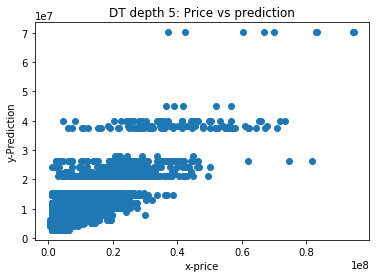

In [65]:
# scatter original vs prediction - poor results
plt.scatter(y_train, y_pred_dt)
plt.title("DT depth 5: Price vs prediction")
plt.xlabel("x-price")
plt.ylabel("y-Prediction")
plt.show()

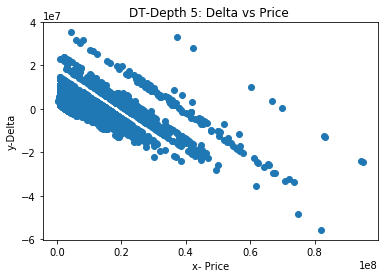

In [66]:
# draw delta price-pred vs price  there are big errors for small & large values
plt.scatter(y_train, (y_pred_dt - y_train))
plt.title("DT-Depth 5: Delta vs Price ")
plt.xlabel("x- Price")
plt.ylabel("y-Delta")
plt.show()

In [67]:
y_pred_dt

array([ 6185013.56766357,  5130923.66998224,  6185013.56766357, ...,
        6185013.56766357,  7923869.64540059,  6185013.56766357])

# Random Forest model

In [68]:
# Step 1: Instantiate a random forest regressor
RF_Model = RandomForestRegressor(n_estimators = 150, 
                              random_state = 2017, 
                              oob_score = True, 
                              max_features = 25,
                              min_samples_leaf = 8)

In [69]:
# Step 2: Train the forest
# Again fill in X and y below with X_train and y_train
RF_Model.fit(X = X_train, y = y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=25, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=8,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=True, random_state=2017,
           verbose=0, warm_start=False)

In [70]:
# Step 3: Make predictions 
# Create predictions for the examples in x_train
y_pred_rf = RF_Model.predict(X = X_train)

np.sqrt(np.mean((y_pred_rf - y_train)**2)) # about 0.37 (if you use 100 trees)

2260663.0222643288

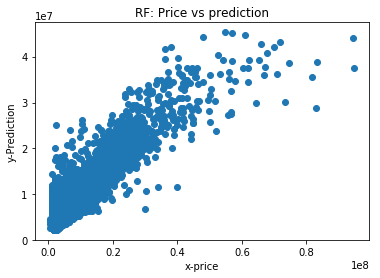

In [71]:
# scatter original vs prediction - poor results
plt.scatter(y_train, y_pred_rf)
plt.title("RF: Price vs prediction")
plt.xlabel("x-price")
plt.ylabel("y-Prediction")
plt.show()

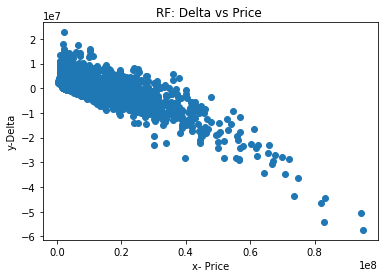

In [72]:
# draw delta price-pred vs price  there are big errors for small & large values
plt.scatter(y_train, (y_pred_rf - y_train))
plt.title("RF: Delta vs Price ")
plt.xlabel("x- Price")
plt.ylabel("y-Delta")
plt.show()

In [73]:
np.sqrt(np.mean((RF_Model.oob_prediction_ - y_train)**2)) # slightly better than a simple tree.

2854788.1820743112

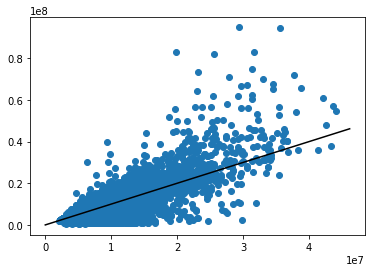

In [74]:
fig, ax = plt.subplots()
plt.scatter(RF_Model.oob_prediction_, y_train)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color = 'black')
plt.show()

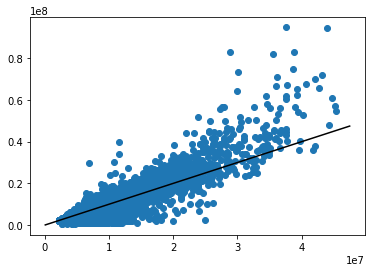

In [75]:
fig, ax = plt.subplots()
plt.scatter(y_pred_rf, y_train)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color = 'black')
plt.show()

In [76]:
# Create a dataframe of the variable importances
df_fi = pd.DataFrame(X_train.columns, columns = ['feature'])
df_fi['fscore'] = RF_Model.feature_importances_[:, ]

In [77]:
df_fi.head()

,feature,fscore
0,full_sq,0.150257
1,life_sq,0.103640
2,floor,0.005349
3,max_floor,0.007492
4,material,0.001029


In [78]:
df_fi['fscore'].max()

0.15025671207075941

In [79]:
df_fi.loc[df_fi['fscore']==0.20407016804311454]

,feature,fscore


In [80]:
df_fi['rel_fscore'] = df_fi['fscore'] / df_fi['fscore'].max()

In [81]:
df_fi.head()

,feature,fscore,rel_fscore
0,full_sq,0.150257,1.000000
1,life_sq,0.103640,0.689751
2,floor,0.005349,0.035600
3,max_floor,0.007492,0.049863
4,material,0.001029,0.006850


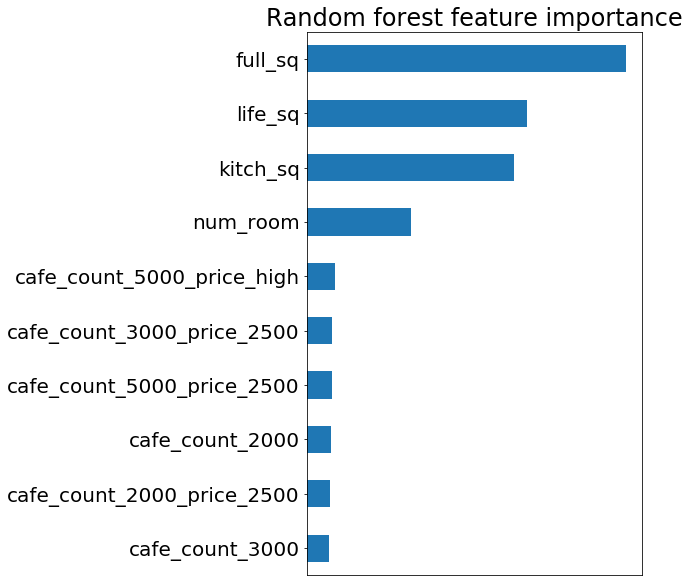

In [82]:
# Plot the relative importance of the top 10 features
df_fi.sort_values('rel_fscore', ascending = False, inplace = True)
df_fi_10 = df_fi[0:10]
df_fi_top=df_fi_10.sort_values('rel_fscore', ascending = True)
df_fi_top.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('Random forest feature importance', fontsize = 24)
plt.xlabel('')
plt.ylabel('')
plt.xticks([], [])
plt.yticks(fontsize=20)
plt.show()

In [83]:
# Create the predictions for the test set

y_RFtest_pred = RF_Model.predict(X_test)
#y_RFtest_pred = np.exp(ylog_pred) - 1

In [84]:
rf_output = pd.DataFrame({'id': test.index, 'price_doc': y_RFtest_pred})


In [ ]:
rf_output.head()

In [ ]:
rf_output.to_csv('output/RandomForest_BL_20052018.csv', index=False)

# Xgboost model

In [85]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}


In [86]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)
dtrain

[0]	train-rmse:8.45743e+06	test-rmse:8.46393e+06
[50]	train-rmse:2.53024e+06	test-rmse:2.89959e+06
[100]	train-rmse:2.21568e+06	test-rmse:2.72349e+06
[150]	train-rmse:2.1111e+06	test-rmse:2.69051e+06
[200]	train-rmse:2.02815e+06	test-rmse:2.67112e+06
[250]	train-rmse:1.96129e+06	test-rmse:2.65839e+06
[300]	train-rmse:1.90308e+06	test-rmse:2.65434e+06


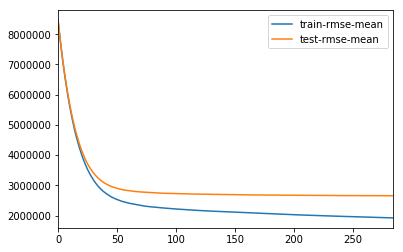

In [87]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [88]:
num_boost_rounds = len(cv_output)
xgb_model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

In [89]:
num_boost_rounds

285

In [90]:
y_pred_xgb = xgb_model.predict(dtrain)

np.sqrt(np.mean((y_pred_xgb - y_train)**2)) # about 0.37 (if you use 100 trees)

2025333.9002465741

In [91]:
y_pred_xgb

array([ 5957223. ,  6295796. ,  5991250. , ...,  5659773.5,  9965618. ,
        5734988. ], dtype=float32)

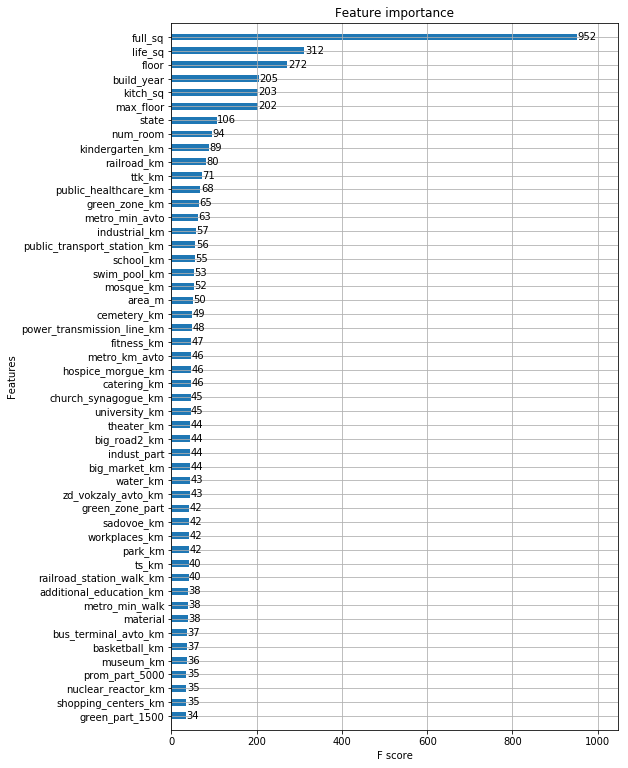

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(xgb_model, max_num_features=50, height=0.5, ax=ax)

**  Create the predictions for the test set **

In [93]:
y_XgbTest_pred = xgb_model.predict(dtest)


In [94]:
xgb_output = pd.DataFrame({'id': test.index , 'price_doc': y_XgbTest_pred})
#xgb_output.head()

**  Change Output File Name **

In [ ]:
#xgb_output.to_csv('output/xgb_V2.5.1_22052018.csv', index=False)

# End Xgboost model

In [ ]:
# For model based on 'price_new' y: Preparing Output file with correct 'price_doc'

In [95]:
xgb_raw_output=xgb_output.set_index('id')
xgb_raw_output.rename(columns={'price_doc':'xgb_price_pred'},inplace=True)
test_data=sberbank_all.loc[sberbank_all['source']=='test','q_rate']
xgb_raw_output=pd.concat([xgb_raw_output,test_data], axis=1)
xgb_raw_output['price_doc']= (xgb_raw_output['xgb_price_pred']*xgb_raw_output['q_rate']).astype(int)


In [96]:
xgb_raw_output.head()

,xgb_price_pred,q_rate,price_doc
id,,,
30474,5604596.5,0.9815,5500911
30475,8296277.0,0.9815,8142795
30476,5436501.0,0.9815,5335925
30477,5891089.0,0.9815,5782103
30478,5155539.5,0.9815,5060162


In [97]:
xgb_output_new = pd.DataFrame({'id': xgb_raw_output.index , 'price_doc': xgb_raw_output['price_doc']})
xgb_output_new.head()

,id,price_doc
id,,
30474,30474,5500911
30475,30475,8142795
30476,30476,5335925
30477,30477,5782103
30478,30478,5060162


In [48]:
#xgb_output_new.to_csv('output/xgb_V2.6.0_22052018.csv', index=False)

In [98]:
sberbank_all.columns[100:200]

Index([u'railroad_station_avto_min', u'ID_railroad_station_avto',
       u'public_transport_station_km', u'public_transport_station_min_walk',
       u'water_km', u'water_1line', u'mkad_km', u'ttk_km', u'sadovoe_km',
       u'bulvar_ring_km', u'kremlin_km', u'big_road1_km', u'ID_big_road1',
       u'big_road1_1line', u'big_road2_km', u'ID_big_road2', u'railroad_km',
       u'railroad_1line', u'zd_vokzaly_avto_km', u'ID_railroad_terminal',
       u'bus_terminal_avto_km', u'ID_bus_terminal', u'oil_chemistry_km',
       u'nuclear_reactor_km', u'radiation_km', u'power_transmission_line_km',
       u'thermal_power_plant_km', u'ts_km', u'big_market_km',
       u'market_shop_km', u'fitness_km', u'swim_pool_km', u'ice_rink_km',
       u'stadium_km', u'basketball_km', u'hospice_morgue_km',
       u'detention_facility_km', u'public_healthcare_km', u'university_km',
       u'workplaces_km', u'shopping_centers_km', u'office_km',
       u'additional_education_km', u'preschool_km', u'big_church_km',

In [99]:
test_data.head()

id
30474    0.9815
30475    0.9815
30476    0.9815
30477    0.9815
30478    0.9815
Name: q_rate, dtype: float64

In [100]:
sberbank_train['incineration_raion'].dtype

dtype('O')

In [101]:
#***
train_2015_q2_index = sberbank_train.loc[sberbank_train['timestamp_new'].dt.year == 2015].loc[sberbank_train['timestamp_new'].dt.month >= 4].loc[sberbank_train['timestamp_new'].dt.month < 7].index
train_2015_q2_index

KeyError: 'timestamp_new'

In [ ]:
#***
tmp=sberbank_train.loc[sberbank_train['year'] == 2015].loc[sberbank_train['q']== 1]
tmp.head(10)

In [102]:
X_train.describe(include=['object'])

ValueError: No objects to concatenate

In [103]:
missing_df=sberbank_all.isnull().sum(axis=0).reset_index()
missing_df.columns=['column_name', 'missing_count']
missing_df.columns
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df

,column_name,missing_count
2,life_sq,8339
3,floor,167
4,max_floor,9540
5,material,9540
6,build_year,16066
7,num_room,9540
8,kitch_sq,17987
9,state,14221
10,product_type,33
17,preschool_quota,8273
